In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

import seaborn as sns
import matplotlib.pyplot as plt

## Деректер жиынын импорттау
Біз pandas-ті мәліметтер жиынтығын оқып, оны деректер шеңберіне жүктеу үшін қолданамыз.

In [13]:
batch_1 = pd.read_excel('toxic.xlsx')
batch_1.columns = [0, 1]
batch_1[1] = batch_1[1].apply(lambda x:1 if x == 'агрессивті' else 0)
batch_1

,0,1
0,"Атанның басы, шегаранын барлығы жабық тұрса, қ...",1
1,Алкаштар кобейп кеттигой аракты неге мулдем ку...,1
2,Осы қызық не бар шетел қанғып,1
3,Осындай заманда қыдырып нелері бар тыныш отырм...,1
4,Бір жерді қысып үйде отыру керек деген осы,1
...,...,...
232,Бізге сіз сияқты келін бұйырса екен,0
233,Өте жарасымды жұп,0
234,"Сәттілік, қуаныштымыз",0
235,"Күшті, шыныменде керемет қой",0


In [14]:
batch_1[1].value_counts()

1    131
0    106
Name: 1, dtype: int64

## Алдын-ала дайындалған BERT моделін жүктеу
Енді алдын-ала дайындалған Берт моделін жүктейік.

In [15]:
# DistilBERT үшін:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Алдын ала дайындалған модельді / токенизаторды жүктейміз
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Дәл қазір айнымалы "модель" құрамында алдын - ала дайындалған ДИСТИЛБЕРТ моделі-BERT нұсқасы бар, ол кішірек, бірақ әлдеқайда жылдам және аз жадты қажет етеді.

## Модель #1: мәліметтер жиынтығын дайындау
Бертке ұсыныстарымызды жібермес бұрын, оларды қажетті форматқа келтіру үшін минималды өңдеуді орындау керек.

### Токенизация
Біздің алғашқы қадамымыз-сөйлемдерді белгілеу-оларды Берт үшін ыңғайлы форматта сөздер мен қосалқы сөздерге бөлу.

In [16]:
tokenized = batch_1[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

### Padding
Токенизациядан кейін" токенизацияланған " - бұл ұсыныстар тізімі-әр сөйлем токендер тізімі ретінде берілген. Біз БЕРТТІҢ барлық мысалдарымызды бірден өңдегенін қалаймыз (бір партия ретінде). Бұл тезірек болады. Осы себепті, біз барлық тізімдерді бірдей мөлшерде толтыруымыз керек, осылайша кірістерді тізімдер тізімінен (әр түрлі ұзындықтар) емес, бір 2-d массив ретінде ұсына аламыз.

In [17]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [18]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(237, 209)

## № 1 Модель: енді-терең оқыту!
Енді бізде модель бар және енгізу дайын, модельді іске қосайық!

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tutorial-sentence-embedding.png" />

'Model ()' функциясы біздің ұсыныстарымызды BERT арқылы іске қосады. Өңдеу нәтижелері "last_hidden_states" - ке қайтарылады.

In [19]:
input_ids = torch.tensor(padded).to(torch.int64) 
attention_mask = torch.tensor(attention_mask).to(torch.int64)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [20]:
features = last_hidden_states[0][:,0,:].numpy()

In [21]:
labels = batch_1[1]

## № 2 Модель: Трейнді/тестті бөлу
Енді мәліметтер жиынтығын оқыту жиынтығы мен тест жиынтығына бөлейік

In [22]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-train-test-split-sentence-embedding.png" />

In [39]:
model = LogisticRegression().fit(train_features,train_labels)
y_preds = model.predict(test_features)
report = classification_report(test_labels, y_preds)
print(report)
acc=accuracy_score(test_labels, y_preds)
print("Logistic Regression, Accuracy Score:" , acc)

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        26
           1       0.79      0.79      0.79        34

    accuracy                           0.77        60
   macro avg       0.76      0.76      0.76        60
weighted avg       0.77      0.77      0.77        60

Logistic Regression, Accuracy Score: 0.7666666666666667


In [40]:
rf=RandomForestClassifier()
rf.fit(train_features,train_labels)
y_preds = rf.predict(test_features)
acc1=accuracy_score(test_labels, y_preds)
report = classification_report(test_labels, y_preds)
print(report)
print("Random Forest, Accuracy Score:",acc1)

              precision    recall  f1-score   support

           0       0.72      0.69      0.71        26
           1       0.77      0.79      0.78        34

    accuracy                           0.75        60
   macro avg       0.75      0.74      0.74        60
weighted avg       0.75      0.75      0.75        60

Random Forest, Accuracy Score: 0.75


In [41]:
nb=GaussianNB()
nb.fit(train_features,train_labels)
y_preds = nb.predict(test_features)
acc2=accuracy_score(test_labels, y_preds)
report = classification_report(test_labels, y_preds)
print(report)
print("Наивты Байес, Дәлдікті Бағалау:",acc2)

              precision    recall  f1-score   support

           0       0.79      0.58      0.67        26
           1       0.73      0.88      0.80        34

    accuracy                           0.75        60
   macro avg       0.76      0.73      0.73        60
weighted avg       0.76      0.75      0.74        60

Наивты Байес, Дәлдікті Бағалау: 0.75


In [42]:
support =LinearSVC(random_state=20)
support.fit(train_features,train_labels)
y_preds = support.predict(test_features)
acc3=accuracy_score(test_labels, y_preds)
report = classification_report(test_labels, y_preds)
print(report)
print("SVM, дәлдікті бағалау:" , acc3)

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        26
           1       0.82      0.82      0.82        34

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60

SVM, дәлдікті бағалау: 0.8


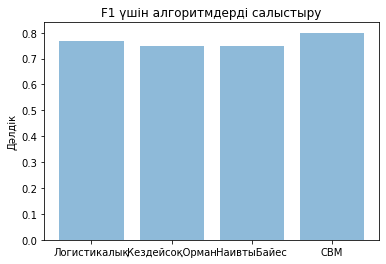

In [43]:
objects = ('Логистикалық', 'КездейсоқОрман', 'НаивтыБайес', 'СВМ')
y_pos = np.arange(len(objects))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Дәлдік')
plt.title('F1 үшін алгоритмдерді салыстыру')
plt.show()